In [ ]:
import keras 

import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# support your google drive in colab
# it's useful to support the kaggle.json credentials
# the code is copied from 
# https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files()\
                       .list(q="name = 'kaggle.json'", fields="files(id)")\
                       .execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Download the data from Kaggle "__Humpback Whale Identification Challenge__"

In [ ]:
!kaggle competitions download -c whale-categorization-playground
!unzip train.zip -d data
!unzip test.zip -d data
!ls data

In [8]:
# reading data
df = pd.read_csv("train.csv")

# encode labels
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit_transform(df.Id)

labels = label_encoder.transform(df["Id"].values)

one_hot_encoder = preprocessing.OneHotEncoder()

labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1))\
                        .toarray()\
                        .tolist()

df["Labels"] = [np.array(l) for l in labels]

df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,Image,Id,Labels
0,00022e1a.jpg,w_e15442c,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,000466c4.jpg,w_1287fbc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,00087b01.jpg,w_da2efe0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,001296d5.jpg,w_19e5482,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0014cfdf.jpg,w_f22f3e3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
from keras.applications import VGG16
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import \
  categorical_accuracy as cat_acc,\
  top_k_categorical_accuracy,\
  categorical_crossentropy

# competition metric
def top_5_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# data generator
data_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      fill_mode='nearest')

train_gen = data_gen.flow_from_dataframe(
    df, 
    "data/train", 
    x_col="Image", 
    y_col="Id",
    target_size=(256, 256), 
    color_mode="rgb", 
    class_mode="categorical", 
    batch_size=32, 
    shuffle=True)

In [12]:
# create model
features = VGG16(input_shape=(256, 256, 3),
                       include_top=False)

model = models.Sequential()

for layer in features.layers:
  model.add(layer)

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.625))
model.add(layers.Dense(len(one_hot_encoder.categories_[0]), 
                       activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(),
              metrics=['acc', top_5_acc])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128       
__________

In [13]:
# Train the model
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.samples/train_gen.batch_size,
    epochs=100,
    verbose=1)

Epoch 1/100
308/307 [==============================] - 259s 841ms/step - loss: 8.2591 - acc: 0.0808 - top_5_acc: 0.0900
Epoch 2/100
308/307 [==============================] - 251s 815ms/step - loss: 7.8231 - acc: 0.0822 - top_5_acc: 0.0937
Epoch 3/100
308/307 [==============================] - 251s 815ms/step - loss: 7.5137 - acc: 0.0822 - top_5_acc: 0.0981
Epoch 4/100
308/307 [==============================] - 250s 813ms/step - loss: 7.2557 - acc: 0.0823 - top_5_acc: 0.0997
Epoch 5/100
308/307 [==============================] - 250s 811ms/step - loss: 7.0782 - acc: 0.0823 - top_5_acc: 0.1029
Epoch 6/100
308/307 [==============================] - 250s 813ms/step - loss: 6.9614 - acc: 0.0822 - top_5_acc: 0.1021
Epoch 7/100
308/307 [==============================] - 250s 812ms/step - loss: 6.8581 - acc: 0.0823 - top_5_acc: 0.1033
Epoch 8/100
308/307 [==============================] - 250s 811ms/step - loss: 6.7594 - acc: 0.0823 - top_5_acc: 0.1053
Epoch 9/100
308/307 [===================

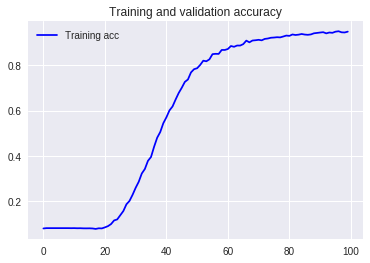

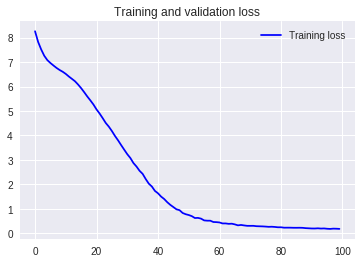

In [15]:
acc = history.history['acc']
val_acc = history.history['top_5_acc']
loss = history.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()